In [4]:
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
import openai
import ast
import os
from dotenv import load_dotenv

dde.backend.backend_name = "pytorch"

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/PINNS')

In [6]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    print("API Key loaded successfully.")
else:
    print("API Key not found.")

API Key loaded successfully.


In [7]:
#Defining the domain
x_min = -5
x_max = 5
t_min = 0
t_max = np.pi/2

In [8]:
#Create spatial and temporal grids for plotting
x = np.linspace(x_min, x_max, 200)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:, None]))

In [9]:
# Define the geometry and time domain for DeepXDE
geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

### Defining the Physical System

In [10]:
# Define the PDE system
def pde(x, y):
  u = y[:, 0:1] # Real part
  v = y[:, 1:2] # Imaginary part

  # Derivatives
  u_t = dde.grad.jacobian(y, x, i=0, j=1)
  v_t = dde.grad.jacobian(y, x, i=1, j=1)
  u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
  v_xx = dde.grad.hessian(y, x, component=1, i=0,j=0)

  #Residuals
  f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
  f_v = -v_t + 0.5 * u_xx + (u**2 + v**2) * u
  return [f_u, f_v]

In [11]:
# Define the initial conditions
def ic_u_value(x):
  return 2/np.cosh(x[:, 0:1])

def ic_v_value(x):
  return np.zeros_like(x[:, 0:1])

def on_initial(x, on_boundary):
  return on_boundary and np.isclose(x[1], t_min)

def on_boundary(x, on_boundary):
  return on_boundary

In [12]:
# Define the periodic boundary conditions
# PeriodicBC(geomtime, component_x, on_boundary, derivative_order=0, component=0)
bc_u = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=0, component=0)
bc_u_x = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=1, component=0)
bc_v = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=0, component=1)
bc_v_x = dde.icbc.PeriodicBC(geomtime, 0, on_boundary, derivative_order=1, component=1)

In [13]:
#Initial Conditions
ic_u = dde.icbc.IC(geomtime, ic_u_value, on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, ic_v_value, on_initial, component=1)

In [14]:
#Combine the PDE, initial conditions and boundary conditions
data = dde.data.TimePDE(geomtime, pde, [ic_u, ic_v, bc_u, bc_u_x, bc_v, bc_v_x], num_domain=5000, num_boundary=200, num_initial=200)

### LLM Integration

In [19]:
def ask_llm_for_hyperparams(client, current_loss, prev_losses, prev_lr, prev_epochs):
    # Format the previous losses as a string
    prev_losses_str = ", ".join([f"{loss:.4e}" for loss in prev_losses])

    prompt = (
        f"Current loss: {current_loss:.4e}\n"
        f"Previous losses: [{prev_losses_str}]\n"
        f"Previous learning rate: {prev_lr}\n"
        f"Previous epochs: {prev_epochs}\n"
        "Analyze the loss trend. Respond with a single line of analysis (e.g., 'Loss has decreased. Adjusting learning rate and epochs.') "
        "followed by a Python dictionary with new 'learning_rate' and 'epochs' values. "
        "If training is complete, return {'training_complete': True}.\n"
        "Example:\n"
        "Loss has decreased. Adjusting learning rate and epochs.\n"
        "{'learning_rate': 0.0005, 'epochs': 3000}"
    )
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert in PINNs and DeepXDE."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=100,
        temperature=0.2,
    )
    return response.choices[0].message.content

# Neural Network Configuration and Training

In [20]:
# Neural Network
learning_rate = 0.001
epochs = 2000
max_bursts = 25
previous_losses = [] #Loss history for LLM analysis

layer_size = [2] + [100] * 8 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

# The Model
model = dde.Model(data, net)

# Instantiate the OpenAI client
client = openai.OpenAI(api_key=api_key)

# Model optimization
for burst in range(max_bursts):
    print(f"======== Burst {burst + 1} ========")

    # Re-compile the model if needed
    model.compile("adam", lr=learning_rate)
    losshistory, train_state = model.train(iterations=epochs, display_every=500)

    # Get the losses
    current_loss = losshistory.loss_train[-1][0]
    previous_losses.append(current_loss)
    print(f"Loss after burst: {current_loss:.4e}")

    # Ask the LLM for hyperparameter suggestions
    llm_reply = ask_llm_for_hyperparams(client, current_loss, previous_losses[-5:], learning_rate, epochs)
    print("LLM suggestion:", llm_reply)

    try:
        # Extract the dictionary from the LLM's response
        hyperparams_str = llm_reply[llm_reply.find("{"):]
        hyperparams = ast.literal_eval(hyperparams_str)


        #Check if training is complete
        if hyperparams.get("training_complete", False):
            print("Training complete as per LLM suggestion. Exiting loop.")
            break

        # Update learning rate and epochs if suggested
        learning_rate = hyperparams.get('learning_rate', learning_rate)
        epochs = hyperparams.get('epochs', epochs)
    except Exception as e:
        print("Failed to parse LLM reply, keeping previous hyperparameters.", e)

======== Burst 1 ========
Compiling model...
Building feed-forward neural network...
'build' took 0.139524 s

'compile' took 2.121229 s

Training model...

0         [4.61e-02, 1.41e-02, 8.77e-01, 8.08e-02, 5.49e-01, 9.40e-04, 3.42e-01, 2.56e-04]    [4.61e-02, 1.41e-02, 8.77e-01, 8.08e-02, 5.49e-01, 9.40e-04, 3.42e-01, 2.56e-04]    []  
500       [1.54e-02, 1.36e-02, 2.80e-02, 1.13e-03, 2.69e-07, 1.46e-03, 2.02e-06, 7.42e-05]    [1.54e-02, 1.36e-02, 2.80e-02, 1.13e-03, 2.69e-07, 1.46e-03, 2.02e-06, 7.42e-05]    []  
1000      [1.21e-02, 2.73e-02, 1.68e-02, 1.30e-03, 2.22e-02, 2.52e-04, 2.98e-06, 1.54e-05]    [1.21e-02, 2.73e-02, 1.68e-02, 1.30e-03, 2.22e-02, 2.52e-04, 2.98e-06, 1.54e-05]    []  
1500      [7.20e-03, 7.23e-03, 1.30e-02, 8.13e-04, 2.56e-05, 4.33e-05, 3.20e-05, 3.93e-05]    [7.20e-03, 7.23e-03, 1.30e-02, 8.13e-04, 2.56e-05, 4.33e-05, 3.20e-05, 3.93e-05]    []  
2000      [5.76e-03, 5.60e-03, 9.78e-03, 8.37e-04, 5.11e-05, 4.89e-05, 1.71e-03, 5.13e-05]    [5.76e-03, 5.60e-0

### Fine Tuning with the L-BFGS optimizer

In [28]:
# Refining the solution using L-BFGS optimizer
model.compile('L-BFGS')
model.train()

Compiling model...
'compile' took 1.023324 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
16500     [1.93e-03, 2.81e-03, 2.45e-03, 4.00e-05, 1.21e-05, 3.52e-06, 2.25e-05, 3.84e-06]    [1.93e-03, 2.81e-03, 2.45e-03, 4.00e-05, 1.21e-05, 3.52e-06, 2.25e-05, 3.84e-06]    []  
16518     [1.93e-03, 2.81e-03, 2.45e-03, 4.00e-05, 1.21e-05, 3.52e-06, 2.25e-05, 3.84e-06]    [1.93e-03, 2.81e-03, 2.45e-03, 4.00e-05, 1.21e-05, 3.52e-06, 2.25e-05, 3.84e-06]    []  

Best model at step 16500:
  train loss: 7.27e-03
  test loss: 7.27e-03
  test metric: []

'train' took 7.667042 s



(<deepxde.model.LossHistory at 0x797ac203a850>,
 <deepxde.model.TrainState at 0x797aa218e950>)

# Visualizations

In [29]:
#Predict the solution
prediction = model.predict(X_test)
u_pred = prediction[:, 0].reshape(100, 200)
v_pred = prediction[:, 1].reshape(100, 200)
h_pred = np.sqrt(u_pred**2 + v_pred**2)

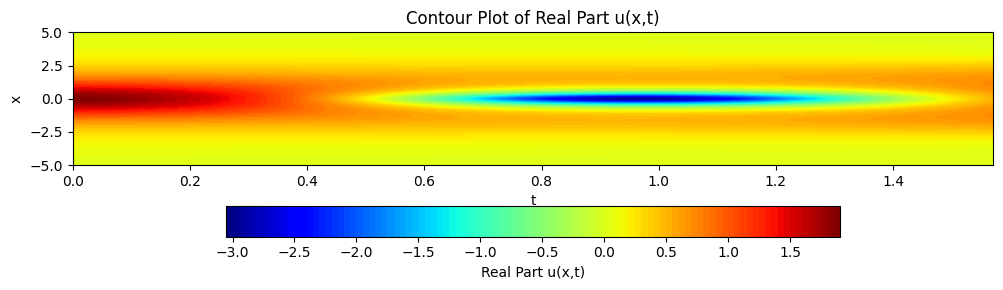

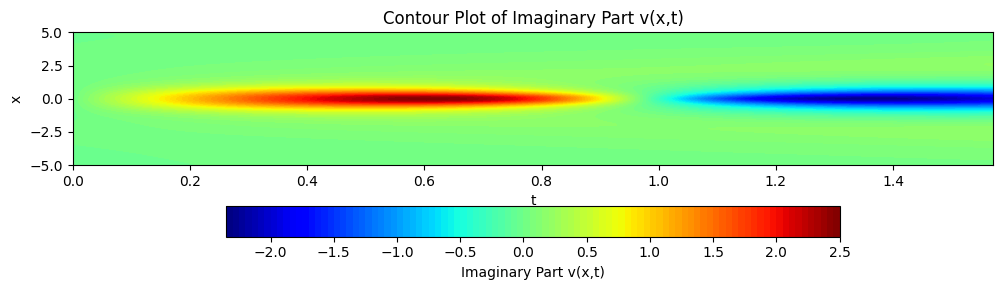

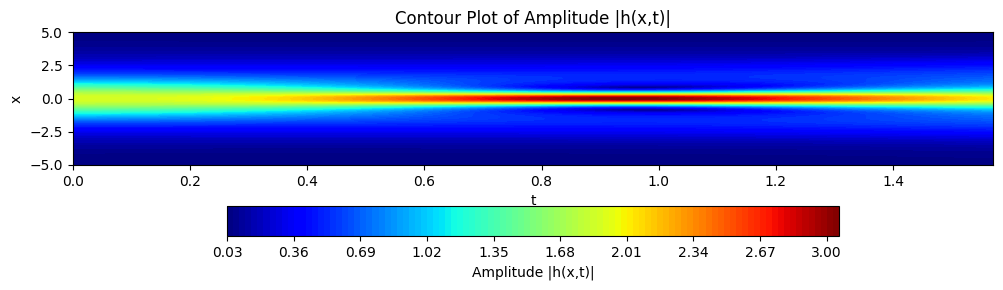

In [30]:
t_length = 10
x_length = 3

#Plot u(x,t) - Real Part
plt.figure(figsize=(t_length, x_length))
contour = plt.contourf(T, X, u_pred, 100, cmap='jet')
cbar = plt.colorbar(contour, orientation = 'horizontal', pad=0.2)
cbar.set_label("Real Part u(x,t)")
plt.title("Contour Plot of Real Part u(x,t)")

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

#Plot u(x,t) - Real Part
plt.figure(figsize=(t_length, x_length))
contour = plt.contourf(T, X, v_pred, 100, cmap='jet')
cbar = plt.colorbar(contour, orientation = 'horizontal', pad=0.2)
cbar.set_label("Imaginary Part v(x,t)")
plt.title("Contour Plot of Imaginary Part v(x,t)")

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Plot |h(x,t)| - Amplitude
plt.figure(figsize=(t_length, x_length))
contour = plt.contourf(T, X, h_pred, 100, cmap='jet')
cbar = plt.colorbar(contour, orientation = 'horizontal', pad=0.2)
cbar.set_label("Amplitude |h(x,t)|")
plt.title("Contour Plot of Amplitude |h(x,t)|")

plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Validation

In [31]:
#Physics Informed Residuals

y_symbolic = model.predict(X_test, operator=pde)
f_u = y_symbolic[0].reshape(100, 200)
f_v = y_symbolic[1].reshape(100, 200)

# Residual statistics
f_u_mean = np.mean(np.abs(f_u))
f_u_max  = np.max(np.abs(f_u))
f_v_mean = np.mean(np.abs(f_v))
f_v_max = np.max(np.abs(f_v))

print(f"Residuals (u): MEan = {f_u_mean:.4e}, Max = {f_u_max:.4e}")
print(f"Residuals (v): MEan = {f_v_mean:.4e}, Max = {f_v_max:.2e}")


Residuals (u): MEan = 2.2714e-02, Max = 4.1359e-01
Residuals (v): MEan = 2.5955e-02, Max = 4.26e-01


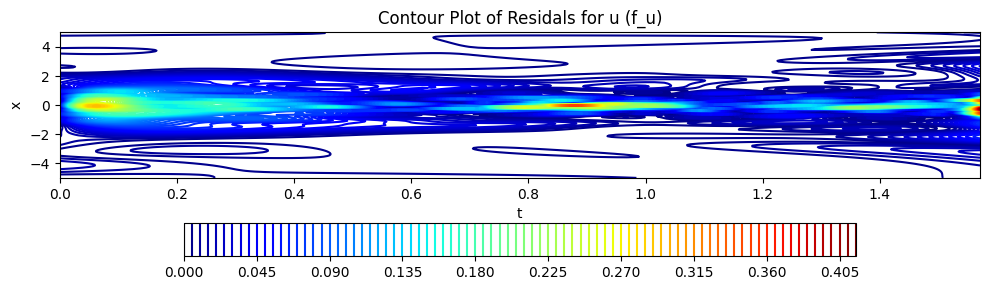

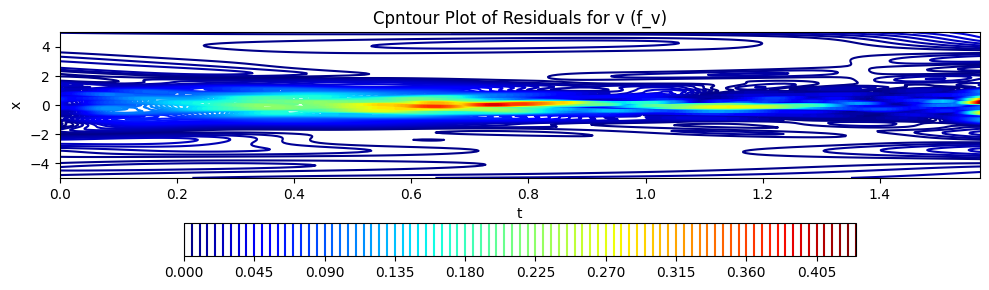

In [32]:
#Plot residuals for u
plt.figure(figsize=(t_length, x_length))
plt.contour(T, X, np.abs(f_u), 100, cmap='jet')
plt.colorbar(orientation = 'horizontal', pad=0.2)
plt.title("Contour Plot of Residals for u (f_u)")

#Set axis labels and limits
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

#Plot residuals for v
plt.figure(figsize=(t_length, x_length))
plt.contour(T, X, np.abs(f_v), 100, cmap='jet')
plt.colorbar(orientation = 'horizontal', pad = 0.2)
plt.title("Cpntour Plot of Residuals for v (f_v)")

#Set axis labels and limits
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(0, np.pi/2)
plt.ylim(-5, 5)
plt.tight_layout()
plt.show()

# Boundary Condition Verification

In [33]:
#Boundary Condition Verification
u_xm5 = u_pred[:, 0] #u at x = -5 for all t
u_xp5 = u_pred[:, -1] #u at x = 5 for all t
v_xm5 = v_pred[:, 0] #v at x = -5 for all t
v_xp5 = v_pred[:, -1] #v at x = 5 for all t

bc_error_u = np.mean(np.abs(u_xm5 - u_xp5))
bc_error_v = np.mean(np.abs(v_xm5 - v_xp5))

print(f"Boundary Condition Error (u): {bc_error_u:.4e}")
print(f"Boundary Condition Error (v): {bc_error_v:.4e}")

Boundary Condition Error (u): 3.2917e-03
Boundary Condition Error (v): 4.6857e-03


# Initial Condition Verification

In [34]:
# Create evaluation points for validation
X_flat = X.flatten()
T_flat = T.flatten()

# Initial condition verification
t0_indices = np.isclose(T_flat, 0)
u_t0 = u_pred[0, :] #First time slice (t=0)
v_t0 = v_pred[0, :] #First time slice (t=0)
u_true_t0 = 2/np.cosh(X_flat[t0_indices])

init_error_u = np.mean(np.abs(u_t0 - u_true_t0))
init_error_v = np.mean(np.abs(v_t0))

print(f"Initial Condition Error (u): {init_error_u:.4e}")
print(f"Initial Condition Error (v): {init_error_v:.4e}")


Initial Condition Error (u): 2.9726e-02
Initial Condition Error (v): 5.4957e-03


# Energy Conservation Analysis

Max energy change: 1.2922e+00


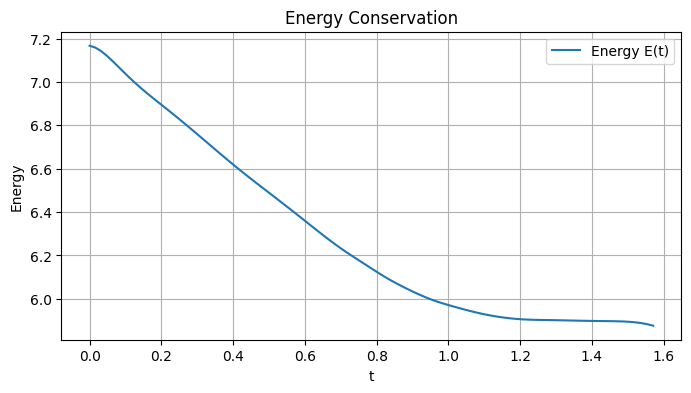

In [35]:
# Energy Conservation
dx = (x_max - x_min) / (len(x) - 1)
E_t = np.sum(u_pred**2 + v_pred**2, axis=1) * dx

#Calculate maximum energy deviation
E_initial = E_t[0]
E_change = np.abs(E_t - E_initial)
max_E_change = np.max(E_change)

print(f"Max energy change: {max_E_change:.4e}")

# Plot energy conservation
plt.figure(figsize=(8,4))
plt.plot(t, E_t, label = "Energy E(t)")
plt.xlabel("t")
plt.ylabel("Energy")
plt.title("Energy Conservation")
plt.legend()
plt.grid()
plt.show()